# Nguồn:
1. https://phamdinhkhanh.github.io/2019/08/10/PytorchTurtorial1.html#3-x%C3%A2y-d%E1%BB%B1ng-m%E1%BA%A1ng-neural-network  <br/>
2. https://nttuan8.com/bai-3-neural-network-2

# Nội dung chính:

1. Kiến trúc mạng CNN
2. Hàm loss
3. Lan truyền ngược
4. Cập nhật trọng số
5. Huấn luyện một mô hình phân lớp <br/>
    5.1 Loading và chuẩn hóa CIFAR10 <br/>
    5.2 Xác định một mạng neural network <br/>
    5.3 Xác định hàm optimizer và hàm loss <br/>
    5.4 Huấn luyện modelv<br/>
    5.5 Kiểm thử<br/>

# 1. Kiến trúc mạng CNN
Xây dựng mạng neural network sẽ trải qua các bước sau:
* Xây dựng kiến trúc mạng
* Phân chia dữ liệu train, test
* Xác định phương pháp optimizer và hàm loss
* Huấn luyện mô hình
* Kiểm thử mô hình


Trong bài này, chúng ta sẽ xây dựng một mạng CNN cho bài toán phân loại ảnh. Để xẩy dựng mạng neural, chúng ta sẽ kế thừa object **nn.Module**. Object này cho phép thực hiện quá trình lan truyền thuận và lan truyền ngược thông qua hàm **forward()** và **backward()**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel 
        # conv2d (input chanels, output chanels, kernel size)
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120) # 6 * 6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Chúng ta phải xác định trước forward function để trả ra kết quả của model ở đầu ra. Dựa trên forward function, hàm **backward** function (là nơi mà gradients tại mỗi layers được tính toán) sẽ được tự động xác định khi bạn sử dụng autograd. Chúng ta cũng có thể sử dụng bất kì một phép biến đổi toán tử Tensor nào trên hàm forward function.

Các tham số huấn luyện (tham số mà có thể thay đổi được trong huấn luyện) của mô hình được trả về bằng hàm **net.parameters()**.

In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight


10
torch.Size([6, 1, 3, 3])


**Lưu ý:** torch.nn chỉ hỗ trợ các mini-batches. Toàn bộ **torch.nn** packages chỉ hỗ trợ đầu vào là mini-batch của mẫu (tức là luôn có 1 chiều trong shape qui định **batch size**), và không tiếp nhận 1 mẫu đơn lẻ.

Chẳng hạn, nn.Conv2d sẽ nhận đầu vào là 4D Tensor của **nSamples x nChannels x Height x Width**. Trong đó chiều đầu tiên là kích thước mẫu (batch size).

Nếu bạn có một mẫu đơn lẻ, chỉ cần sử dụng **input.unsqueeze(0)** để thêm vào một chiều batch size giả mạo.

# 2. Hàm loss
Một hàm loss sẽ nhận 1 cặp (output, target) và tính toán giá trị khoảng cách giữa output và giá trị target.

Có một số dạng loss function khác nhau mà chúng ta có thể tham khảo:
https://pytorch.org/docs/stable/nn.html

Dạng đơn giản nhất là **nn.MSELoss** (trung bình bình phương sai số) tính toán trung bình bình phương sai số giữa giá trị output và giá trị target.

Chúng ta có thể xem ví dụ như bên dưới:

In [6]:
input = torch.randn(1, 1, 32, 32)
output = net(input)
print(output)

tensor([[-0.1270, -0.1098,  0.0137,  0.0489, -0.1219, -0.0035,  0.0028, -0.1137,
          0.0592, -0.1153]], grad_fn=<AddmmBackward>)


In [7]:
target = torch.randn(10) # a dummy target, for example
target = target.view(1, -1) # make it same shape as output
print(target)

tensor([[-0.2137, -2.7222, -0.5496,  0.7046,  2.0571, -0.7265,  0.2586,  1.8118,
          1.1165,  1.3097]])


In [8]:
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.9772, grad_fn=<MseLossBackward>)


Tiến trình backward của hàm loss function sẽ sử dụng thuộc tính **.grad_fn** của nó để lần tìm trên đồ thị tính toán quá trình biến đổi tensor như bên dưới:

*input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d -> view -> linear -> relu -> linear -> relu -> linear -> MSELoss -> loss*

Khi ta gọi vào hàm **loss.backward()**, toàn bộ graph sẽ tính toán đạo hàm của loss function, các tensors trong graph có thuộc tính **requires_grad = True** thì sẽ có tensor .grad được cập nhật gradient theo trình tự lũy tiến.

In [9]:
print(loss.grad_fn) # MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # Relu

# 3. Lan truyền ngược
Để lan truyền ngược chúng ta sử dụng hàm **loss.backward()**. Nhưng trước đó chúng ta cần xóa những gradients đang có và các gradient khác sẽ tích lũy vào gradient hiện có.

Bên dưới chúng ta sẽ cùng gọi vào hàm **loss.backward()**, và chúng ta phải nhìn vào hệ số chệch của conv1 gradient trước và sau khi backward.

In [10]:
net.zero_grad() # chuyển về 0 toàn bộ các gradient trong bộ nhớ đệm của toàn bộ các parameters.
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0191, -0.0053,  0.0098,  0.0137,  0.0011,  0.0201])


# 4. Cập nhật trọng số
Công thức đơn giản để cập nhật trọng số là:

*weight = weight - learning_rate * gradient*

Chúng ta có thể triển khai bằng sử dụng python code đơn giản như sau:

In [12]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)


Trong đó **_sub()** là một hàm inplace của phép trừ.

Tuy nhiên khi sử dụng mạng neural networks, bạn muốn sử dụng đa dạng các phương pháp cập nhật gradient descent khác nhau như SGD, Nesterov-SGD, Adam, RMSProp,…. Do đó sử dụng package torch.optim chúng ta có thể thực hiện được toàn bộ nhữn phương pháp gradient descent này một cách đơn giản.

In [13]:
import torch.optim as optim

# Create your optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.001)

# in your training loop
optimizer.zero_grad() # zero gradients buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() #Does update

Hàm **criterion()** được sử dụng để tính loss function. **loss.backward()** sẽ thực hiện quá trình lan truyền ngược và **optimizer.step()** được dùng để cập nhật gradients theo phương pháp optimization.

# 5. Huấn luyện một mô hình phân lớp

Như vậy chúng ta đã hình dung cơ bản được cách nào để xây dựng một mạng neural và làm thế nào để tính toán loss function và cập nhật trọng số.

Nhưng bước quan trọng nhất của mô hình đó là chuyển hóa dữ liệu từ raw data sang numpy array của python để model có thể đọc hiểu được.

Các định dạng dữ liệu thông thường bạn làm việc sẽ là hình ảnh, âm thanh, đoạn text, đoạn video. Bạn có thể sử dụng các packages của python để đọc những dữ liệu này dưới dạng numpy và sau đó convert những array này sang torch tensor.

* Đối với hình ảnh, packages có thể sử dụng là pillow, opencv.
* Đối với âm thanh chúng ta có thể sử dụng scipy hoặc librosa.
* Đối với định dạng text NLTK và Spacy có thể hữu ích.

Để sử dụng chuyên biệt cho đọc và xử lý ảnh trên pytorch chúng ta có thể sử dụng một packages là **torchvision**. Package này có thể load được các bộ ảnh lớn như CIFAR10, MNIST, … và biến đổi dữ liệu ảnh thông qua các module **torchvision.datasets, torchvision.utils.data.DataLoader** hay **visualization**.

Chúng ta sẽ đi qua các step sau đây:

* Load hình ảnh và chuẩn hóa tập dữ liệu hình ảnh CIFAR10 sử dụng torchvision.
* Xác định kiến trúc mạng neural.
* Xác định hàm loss function.
* Huấn luyện model trên tập training.
* Đánh giá model trên tập testing.

## 5.1 Loading và chuẩn hóa CIFAR10
Sử dụng torchvision chúng ta có thể dễ dàng load các hình ảnh trong CIFAR10. Đầu ra của torchvision dataset là các hình ảnh PILImage nằm trong khoảng [0, 1]. Chúng ta sẽ biến đổi chúng thành các Tensors chuẩn hóa về khoảng [-1, 1].

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

# Xây dựng một chuẩn hóa đầu vào cho ảnh

transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Khởi tạo dữ trainset qui định dữ liệu training
trainset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True, 
                                       download = True, transform = transform)

# Khởi tạo trainloader qui định cách truyền dữ liệu vào model theo batch. 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, 
                                         shuffle = True, num_workers = 2)

# Tương tự nhưng đối với test
testset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = False, 
                                      download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                              shuffle = False, num_workers = 2)

# Nhãn cho các class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [15]:
print(type(trainset[0][0]))
print(trainset[0][0].size())

<class 'torch.Tensor'>
torch.Size([3, 32, 32])


Các object trainset và testset là dữ liệu mà chúng ta sử dụng để huấn luyện model (chính là list các tensor đại diện cho các bức ảnh). Những object còn lại bao gồm trainLoader và testLoader qui định dữ liệu chúng ta lấy từ đâu và cách thức chúng ta truyền dữ liệu vào mô hình theo batch với kích thước bao nhiêu, có thực hiện shuffle các batch sau khi hết một epoch hay không?

Hiển thị một số hình ảnh bằng matplotlib

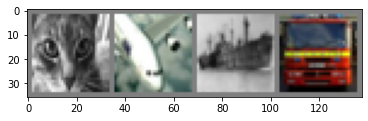

  cat plane  ship truck


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
print(type(trainloader))
print(images.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 3, 32, 32])


## 5.2 Xác định một mạng neural network

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d: input nodes, output nodes, kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 5.3 Xác định hàm optimizer và hàm loss

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.1)

## 5.4 Huấn luyện model

Chúng ta sẽ khởi tạo một vòng loop bao gồm 2 epochs trong đó mỗi một epochs sẽ truyền toàn bộ các data iterator như đầu vào của mạng nơ ron. Bên trong mỗi epoch chúng ta xác định:

* output của mô hình.
* hàm loss function.
* phương pháp optimize.
* thực hiện quá trình feed forward.

Mọi thứ diễn ra khá đơn giản theo như code bên dưới

In [21]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Thiết lập trạng thái huấn luyện cho mô hình
        # model.train()
        # get the inputs, data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
        
        # Thiết lập trạng thái đánh giá cho mô hình, ở bước này thì mô hình không backward và cập nhật trọng số
        # model.eval()
        # for x_batch,y_batch in valid_dataloader:
        #    pred = model(x_batch)
        #    val_loss = loss_criterion(pred, y_batch)
print('Finished Training')

[1,  2000] loss: 2.305
[1,  4000] loss: 2.302
[1,  6000] loss: 2.299
[1,  8000] loss: 2.295
[1, 10000] loss: 2.284
[1, 12000] loss: 2.244
[2,  2000] loss: 2.123
[2,  4000] loss: 2.036
[2,  6000] loss: 1.954
[2,  8000] loss: 1.921
[2, 10000] loss: 1.862
[2, 12000] loss: 1.803
Finished Training


## 5.5 Kiểm thử
Như vậy chúng ta đã hoàn thành 2 lượt huấn luyện dữ liệu trên toàn bộ tập training dataset. Sau đây chúng ta cần kiểm tra xem kết quả mô hình sau huấn luyện như thế nào trên dữ liệu test dataset.

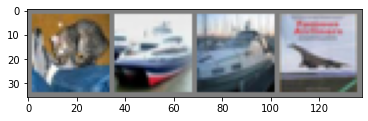

GroundTruth:   cat  ship  ship plane


In [22]:
# Hiển thị một vài dữ liệu
# Sử dụng hàm iter để biến testloader thành 1 iterator, từ đó có thể lấy các giá trị tiếp theo.
dataiter = iter(testloader)
images, labels = dataiter.next()

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: {}'.format(' '.join('%5s' % classes[labels[j]] for j in range(4))))

Khác với tensorflow khi dự báo chúng ta cần phải sử dụng hàm predict. Để dự báo nhãn cho tập data test chúng ta chỉ cần truyền raw data vào object net. Mô hình sẽ tự động thực hiện một quá trình lan truyền thuận và tính ra phân phối xác xuất ở đầu ra.

In [23]:
outputs = net(images)
print(type(outputs))
print(outputs.shape)

<class 'torch.Tensor'>
torch.Size([4, 10])


Lấy ra nhãn dự báo dựa vào xác xuất lớn nhất của phân phối xác xuất đầu ra.

In [24]:
_,  predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


Kiểm tra trên toàn bộ các quan sát.

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 37 %


Kiểm tra mức độ chính xác trên từng class một.

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 46 %
Accuracy of  bird : 10 %
Accuracy of   cat : 18 %
Accuracy of  deer : 28 %
Accuracy of   dog : 34 %
Accuracy of  frog : 47 %
Accuracy of horse : 53 %
Accuracy of  ship : 39 %
Accuracy of truck : 35 %


Để huấn luyện trên gpu, đầu tiên chúng ta cần chọn **device** (Xem lại bài trước), sau đó chỉ cần **net.to(device)**. Hãy nhớ rằng, bạn phải gửi inputs và targets tại mỗi bước huấn luyện lên GPU.

**Chú ý:**

Mọi người để ý ở trên, để áp dụng ReLU activation mình dùng

**F.relu(...)**

Tuy nhiên trong module torch.nn cũng có

**torch.nn.ReLU(...)**

Về cơ bản thì 2 hàm thực hiện chức năng giống nhau, áp dụng ReLU activation function. Tuy nhiên điểm khác nhau lớn nhất là: F.relu như một hàm tính ReLU bình thường, tuy nhiên nn.ReLU tạo ra 1 nn.Module giống như các layer Linear, Conv2d. Do đó nn.ReLU có thể thêm vào nn.Sequential, cũng như register các hàm hook.

Những hàm để xây dựng model như Linear, Conv2d, ReLU, max_pool2d đều có cả 2 dạng nn và F. Nó phụ thuộc vào phong cách code và xây dựng model của mỗi người. Mình thì thường dùng nn với những hàm có tham số, còn không có tham số như ReLU, max_pool2d thì dùng functional (F).